In [77]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision
import wandb  # Step 8: Import wandb for experiment tracking
import time
from torch.optim import Adam
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import math
from torchvision.models import resnet50

batch_size = 128
learning_rate = 1e-3
image_size = 64

data_dir = '../data/anime_faces/'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset and split into train and validation sets
dataset = ImageFolder(data_dir, transform=transform)
val_size = int(len(dataset) * 0.1)  # 10% for validation
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

# Step 9: Creating a dataframe to keep track of metrics for each epoch
metrics_df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss", "time"])

## Old landscape images (bad training)

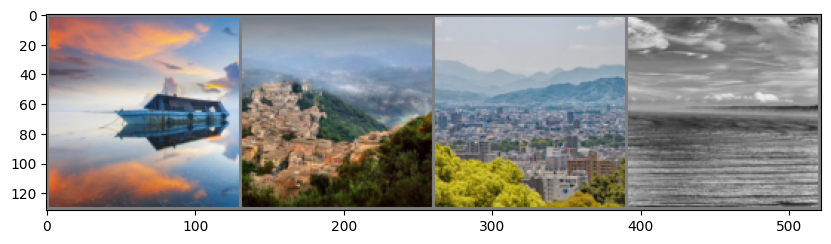

In [76]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # convert from Tensor image

for images, labels in train_dataloader:
    imshow(torchvision.utils.make_grid(images[0:4]))
    break

## Images where training was ok

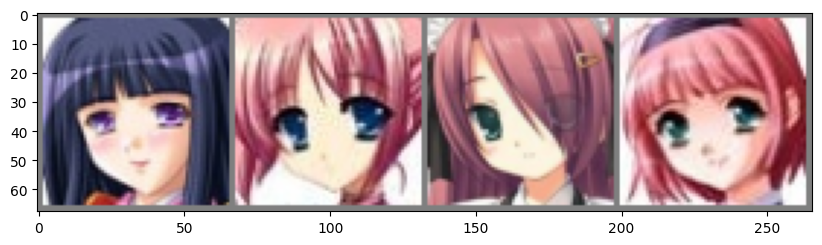

In [2]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # convert from Tensor image

for images, labels in train_dataloader:
    imshow(torchvision.utils.make_grid(images[0:4]))
    break

In [3]:
len(train_dataloader), len(val_dataloader)

(59, 7)

In [3]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, image_input_dim=128, h_dim=9216, z_dim=128, encoder_type="base"):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.image_channels = image_channels
        self.h_dim = h_dim
        self.image_input_dim = image_input_dim

        if encoder_type == "base":
        
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(h_dim, z_dim*2)  # expects an input of h_dim=2304
            )
            
            # Decoder model 
            self.decoder = nn.Sequential(
                nn.Linear(z_dim, math.floor(image_input_dim/16) * math.floor(image_input_dim/16) * 512),
                nn.ReLU(),
                nn.Unflatten(1, (512, math.floor(image_input_dim/16), math.floor(image_input_dim/16))),
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),
                nn.Sigmoid()
            )
        
        if encoder_type == "simple":
            self.encoder = nn.Sequential(
                nn.Conv2d(image_channels, 16, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(16, 32, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(h_dim, z_dim*2)
            )

            self.decoder = nn.Sequential(
                nn.Linear(z_dim, math.floor(image_input_dim/16) * math.floor(image_input_dim/16) * 128),
                nn.ReLU(),
                nn.Unflatten(1, (128, math.floor(image_input_dim/16), math.floor(image_input_dim/16))),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(16, image_channels, kernel_size=4, stride=2, padding=1),
                nn.Sigmoid()
            )
        

        if encoder_type == "resnet50":
            # Use a pre-trained ResNet50 model as the encoder
            self.encoder = resnet50(pretrained=True)
        
            # Freeze the ResNet model
            for param in self.encoder.parameters():
                param.requires_grad = False
            
            # Modify the final layer to output to the latent space dimension
            num_ftrs = self.encoder.fc.in_features
            self.encoder.fc = nn.Linear(num_ftrs, z_dim * 2)  # 2 for mean and log variance.

            # Decoder model 
            self.decoder = nn.Sequential(
                nn.Linear(z_dim, 8 * 8 * 512),   # This value might need adjusting
                nn.ReLU(),
                nn.Unflatten(1, (512, 8, 8)),
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
                nn.Sigmoid()
            )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def forward(self, x):
        mu_logvar = self.encoder(x).view(-1, 2, self.z_dim)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    
class Generator(nn.Module):
    def __init__(self, z_dim=128, image_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 2*2*512),
            nn.ReLU(),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, image_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(8192, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [5]:
vae = VAE(encoder_type="base", image_input_dim=image_size, h_dim=1024, z_dim=512).cuda()
optimizer = Adam(vae.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

run = wandb.init(project="vae_training", config={
    "input_size": [3, image_size, image_size],
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "architecture": "VAE-base-anime"
})

config = wandb.config

def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE, KLD

def train(epoch):
    vae.train()  
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = vae(data)
        loss, mse, kld = vae_loss(recon_batch, data, mu, logvar)  # Step 3: Unpack MSE and KLD
        
        loss.backward()

        for name, param in vae.named_parameters():
            if param.grad is not None:
                wandb.log({name+"_grad_norm": param.grad.data.norm(2).item()})
        
        optimizer.step()

        wandb.log({"train_loss": loss.item() / len(data), "train_mse": mse / len(data), "train_kld": kld / len(data)})

def validate(epoch):
    vae.eval()  
    val_loss = 0
    val_mse = 0
    val_kld = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_dataloader):
            data = data.cuda()
            recon_batch, mu, logvar = vae(data)
            loss, mse, kld = vae_loss(recon_batch, data, mu, logvar)  # Step 3: Unpack MSE and KLD
            val_loss += loss.item()
            val_mse += mse.item()  # Step 3: Accumulate MSE
            val_kld += kld.item()  # Step 3: Accumulate KLD

    val_loss /= len(val_dataloader.dataset)
    val_mse /= len(val_dataloader.dataset)  # Step 3: Compute average MSE
    val_kld /= len(val_dataloader.dataset)  # Step 3: Compute average KLD

    wandb.log({"val_loss": val_loss, "val_mse": val_mse, "val_kld": val_kld})

    # Step 2: Visualize a 3x3 grid of generated images
    with torch.no_grad():
        sample = torch.randn(9, vae.z_dim).to(device)
        generated = vae.decoder(sample).cpu()
        grid = torchvision.utils.make_grid(generated.view(9, vae.image_channels, image_size, image_size), nrow=3)
        wandb.log({"generated_images": [wandb.Image(grid, caption="Generated Images")]})

    return val_loss

num_epochs = 100
best_loss = float('inf')
no_improve = 0

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    start_time = time.time()
    train(epoch)
    val_loss = validate(epoch)
    end_time = time.time()

    epoch_time = end_time - start_time
    wandb.log({"epoch_time": epoch_time})

    # Step 7: Check if validation loss has improved
    if val_loss < best_loss:
        best_loss = val_loss
        no_improve = 0
        torch.save(vae.state_dict(), os.path.join(wandb.run.dir, 'best_model.pth'))
    else:
        no_improve += 1

    # Step 7: Stop training if validation loss has not improved in 10 epochs
    if no_improve >= 10:
        print('Early stopping.')
        break

    # Step 9: Store metrics for each epoch in the dataframe
    metrics_df.loc[epoch] = [epoch+1, wandb.run.summary["train_loss"], wandb.run.summary["val_loss"], epoch_time]

    if epoch % 5 == 0:
        torch.save(vae.state_dict(), os.path.join(wandb.run.dir, 'model_{}.pth'.format(epoch)))

# Step 9: Save the dataframe to a csv file
metrics_df.to_csv(f'../data/runs/metrics_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv', index=False)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaguar (22hs_i4ds20). Use `wandb login --relogin` to force relogin


Epochs:  98%|█████████▊| 98/100 [02:50<00:03,  1.74s/it]

Early stopping.


decoder.0.bias_grad_norm,▂▅▄▄▃▅▂▄▄▄█▂▄▂▂▂▄▂▂▁▂▂▂▂▂▁▆▁▃▂▁▂▁▂▂▁▂▁▁▂
decoder.0.weight_grad_norm,▃█▅▄▃▄▂▃▃▃▅▂▃▂▃▂▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁
decoder.3.bias_grad_norm,▃▆▂▄▄▅▁▄▃▄█▁▅▂▂▂▃▂▂▁▃▁▁▃▂▁▆▁▃▂▁▁▁▂▁▁▁▁▁▂
decoder.3.weight_grad_norm,▁▄▂▃▄▅▂▄▃▄▇▂▄▃▃▃▄▃▃▂▃▃▃▃▃▂█▃▄▃▃▃▃▃▃▂▃▃▃▃
decoder.5.bias_grad_norm,▃▅▃▄▄▅▁▄▃▄█▂▅▂▂▃▃▂▂▁▃▁▂▃▂▁▇▁▃▂▂▁▁▂▁▁▂▁▁▂
decoder.5.weight_grad_norm,▁▅▃▄▅▅▂▄▃▄▇▂▄▂▂▃▄▃▃▂▃▂▂▄▂▂█▂▄▃▂▂▂▃▂▂▃▂▂▃
decoder.7.bias_grad_norm,█▄▂▄▃▄▁▄▄▄█▂▅▂▂▃▃▃▂▁▃▂▂▄▂▁█▁▄▂▁▁▂▃▂▁▂▂▂▂
decoder.7.weight_grad_norm,▂▆▃▅▆▇▃▄▂▄▆▂▃▂▁▃▅▂▂▁▃▂▂▃▂▁█▁▄▂▂▁▁▂▂▁▂▂▂▂
decoder.9.bias_grad_norm,█▂▁▂▂▃▁▂▂▂▃▁▂▁▁▂▂▁▁▁▂▁▁▂▁▁▃▁▂▁▁▁▁▂▁▁▁▁▁▁
decoder.9.weight_grad_norm,▃▆▄▆▇█▄▃▃▄▅▂▃▂▂▃▇▂▃▁▃▂▂▃▂▁▇▂▃▂▂▁▁▂▁▁▂▁▁▂
encoder.0.bias_grad_norm,▂▄▃▄▅▆▂▅▃▄█▁▄▃▂▃▄▂▂▁▃▂▂▃▂▁▇▂▄▂▁▁▁▂▂▁▂▂▂▂


In [5]:
vae = VAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(image_input_dim=image_size, h_dim=1024, z_dim=256)
model.load_state_dict(torch.load("../data/runs/anime-base-lr-1e3-z-dim-256/best_model.pth", map_location=device))
model.eval()
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=8192, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU()
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): S

In [6]:
from torch.utils.tensorboard import SummaryWriter
import torchvision

# Create a SummaryWriter to write to TensorBoard
writer = SummaryWriter()

with torch.no_grad():  # We don't need gradients for this part
    for i, (data, _) in enumerate(val_dataloader):
        data = data.to(device)
        reconstruction, mu, logvar = model(data)
        data_grid = torchvision.utils.make_grid(data)
        reconstruction_grid = torchvision.utils.make_grid(reconstruction)
        # Write the grids to TensorBoard
        writer.add_image('Original Images', data_grid, i)
        writer.add_image('Reconstructed Images', reconstruction_grid, i)


2023-07-09 12:24:39.254884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 12:24:39.992740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
from torch.utils.tensorboard import SummaryWriter
import torchvision
import numpy as np

# Create a SummaryWriter to write to TensorBoard
writer = SummaryWriter()

# List to hold our encoded images
encoded_images = []
# List to hold the corresponding latent vectors
latent_vectors = []

with torch.no_grad():  # We don't need gradients for this part
    for i, (data, _) in enumerate(val_dataloader):
        data = data.to(device)
        reconstruction, mu, logvar = model(data)
        for rec in reconstruction:
            # We just add the normalized image tensor to our list
            # Make sure the image tensor is in the shape (C, H, W) and in the range [0, 1]
            rec_norm = (rec - rec.min()) / (rec.max() - rec.min())
            encoded_images.append(rec_norm.cpu().unsqueeze(0))
        # Flatten and detach the mu tensor, then add it to our list
        latent_vectors.append(mu.detach().cpu().numpy())

# Convert the list of images into a single 4D tensor
encoded_images = torch.cat(encoded_images, 0)

# Convert the list of arrays into a single 2D array
latent_vectors = np.concatenate(latent_vectors, axis=0)

writer.add_embedding(mat=latent_vectors, label_img = encoded_images)

# Close the writer
writer.close()


## Latent Space interpolation (from one image to another)

In [59]:
# Get latent representations
writer = SummaryWriter()
recon1, mu1, logvar1 = model(data1)
recon2, mu2, logvar2 = model(data2)
recon1, mu1, logvar1 = recon1[0], mu1[0], logvar1[0]
recon2, mu2, logvar2 = recon2[1], mu2[1], logvar2[1]
std1 = torch.exp(0.5*logvar1)
eps1 = torch.randn_like(std1)
sample1 = eps1.mul(std1).add_(mu1)

std2 = torch.exp(0.5*logvar2)
eps2 = torch.randn_like(std2)
sample2 = eps2.mul(std2).add_(mu2)
interpolation = torch.stack([sample1 + (sample2 - sample1) * t for t in np.linspace(0, 1)])
with torch.no_grad():
    interpolations = model.decoder(interpolation).cpu()
images = []
for i, interp in enumerate(interpolations):
    writer.add_images('Interpolation', interp.unsqueeze(0), i)
    interp_image = torchvision.transforms.ToPILImage()(interp)
    images.append(np.array(interp_image))

# Create gif from images
imageio.mimsave('latent_space_traversal.gif', images)
writer.close()

## Reconstruction Heat Map with error metric

In [72]:
def calculate_fid_score(mu1, sigma1, mu2, sigma2):
    ssd = np.sum((mu1 - mu2)**2.0)
    covmean_diff = np.sum((sigma1 - sigma2)**2.0)
    fid = ssd + covmean_diff
    return fid

mu_vals_real = []
logvar_vals_real = []
mu_vals_recon = []
logvar_vals_recon = []

with torch.no_grad():
    for data, _ in val_dataloader:
        data = data.to(device)
        recon, mu, logvar = model(data)
        
        mu_vals_real.append(mu.cpu().numpy())
        logvar_vals_real.append(logvar.cpu().numpy())
        
        recon_recon, mu_recon, logvar_recon = model(recon)
        mu_vals_recon.append(mu_recon.cpu().numpy())
        logvar_vals_recon.append(logvar_recon.cpu().numpy())
        
mu_vals_real = np.concatenate(mu_vals_real, axis=0)
logvar_vals_real = np.concatenate(logvar_vals_real, axis=0)
mu_vals_recon = np.concatenate(mu_vals_recon, axis=0)
logvar_vals_recon = np.concatenate(logvar_vals_recon, axis=0)

sigma_vals_real = np.exp(logvar_vals_real)
sigma_vals_recon = np.exp(logvar_vals_recon)

fid_score = calculate_fid_score(mu_vals_real.mean(axis=0), sigma_vals_real.mean(axis=0), mu_vals_recon.mean(axis=0), sigma_vals_recon.mean(axis=0))

print('FID Score:', fid_score)

FID Score: 1.2395575
